In [1]:
import numpy as np
import os
from pyboy import PyBoy
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.ppo import MultiInputPolicy
from stable_baselines3.common.env_checker import check_env
from gymnasium.wrappers import TransformObservation
from gymnasium.spaces import Box, Dict
from pyboy import PyBoy
from stable_baselines3 import PPO
from stable_baselines3.ppo import MultiInputPolicy
from gymnasium.wrappers import TransformObservation
from gymnasium.spaces import Box, Dict
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import numpy as np

# List of actions
ACTIONS = ['a', 'b', 'left', 'right', 'up', 'down']

# Definir posiciones objetivo con orientación (x, y, map, orientation)
TARGET_POSITIONS = [
    (16, 8, 80, 1),  # Target Position 1
    (17, 9, 80, 2),  # Target Position 2
    (16, 10, 80, 0)   # Target Position 3
]
class GenericPyBoyEnv(Env):
    def __init__(self, pyboy, debug=False, render_mode=False, max_gameplay_time=1080000):
        super().__init__()
        self.pyboy = pyboy
        self.debug = debug
        self.render_mode = render_mode
        self.max_gameplay_time = max_gameplay_time
        self.current_gameplay_time = 0
        
        self.action_space = spaces.Discrete(len(ACTIONS))
        self.observation_space = Dict({
           "info": Box(0, 255, (4,), dtype=np.float32)  # Added orientation
        })
        
        self.visited_maps = set()
        self.visited_positions = set()
        self.last_pos = None
        
        if not self.debug:
            self.pyboy.set_emulation_speed(60 if not self.render_mode else 3)
        
        self.load_state()

    def load_state(self):
        with open("zero_state.state", "rb") as f:
            self.pyboy.load_state(f)

    def get_observation(self):
        
        pos_x = self.pyboy.memory[0xC0D4]
        pos_y = self.pyboy.memory[0xC0D5]
        map_id = self.pyboy.memory[0xC92D]
        orientation = self.pyboy.memory[0xC0D8]

        return {
            "info": np.array([pos_x, pos_y, map_id, orientation], dtype=np.float32)
        }

    def step(self, action):
        self.pyboy.button(ACTIONS[action])
        for _ in range(60):
            self.pyboy.tick()
            self.current_gameplay_time += 1
            
       
        
        pos_x = self.pyboy.memory[0xC0D4]
        pos_y = self.pyboy.memory[0xC0D5]
        map_value = self.pyboy.memory[0xC92D]
        orientation = self.pyboy.memory[0xC0D8]
        full_position = (pos_x, pos_y, map_value, orientation)

        timeout = self.current_gameplay_time >= self.max_gameplay_time
        # Check if the agent reached *any* of the target positions and pressed 'A'
        reached_target = full_position in TARGET_POSITIONS and action == 0
        #reached_target = self.pyboy.memory[0xC92D] == 107
        reward = -0.001

        if map_value not in self.visited_maps:
            #print("New Map")
            reward += 1
            
        if reached_target:
            #print("You Win!")
            reward += 10  # Large reward for reaching the goal and pressing 'A'

        # If timeout happens, give a small penalty
        #if timeout:
            #reward -= 10
         #   print("GAME OVER")

        self.visited_maps.add(map_value)
        self.visited_positions.add(full_position)
        self.last_pos = full_position

        # Done condition: timeout or reaching target position & pressing 'A'
        done = timeout or reached_target

        return self.get_observation(), reward, done, False, {}

    def reset(self, seed=None, **kwargs):
        self.load_state()
        self.current_gameplay_time = 0
        self.visited_positions.clear()
        self.visited_maps.clear()
        return self.get_observation(), {}

    def close(self):
        self.pyboy.stop()


In [2]:
from pyboy import PyBoy
from stable_baselines3 import PPO
from stable_baselines3.ppo import MultiInputPolicy
from gymnasium.wrappers import TransformObservation
from gymnasium.spaces import Box, Dict
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import numpy as np

# Creating a training environment
def make_env():
    pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
    train_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)

    # Observation
    train_env = TransformObservation(
        train_env,
        lambda obs: {"info": obs["info"]}, 
        observation_space=Dict({
            "info": Box(low=0, high=255, shape=(4,), dtype=np.float32)
        })
    )

    # Monitor for later analitics
    return Monitor(train_env, filename="./ppo_medarot_logs")

# Vectorizing for multiple environments
num_envs = 8
vec_env = SubprocVecEnv([lambda: make_env() for _ in range(num_envs)])


# Configurar PPO
model = PPO(
    MultiInputPolicy,
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    n_steps=4096,  # Debe ser múltiplo de num_envs
    batch_size=512,
    gamma=0.999,
    gae_lambda=0.95,
    ent_coef=0.1,
    clip_range=0.2,
    tensorboard_log="./ppo_tensorboard/"
)

# Entrenar y guardar el mejor modelo
model.learn(total_timesteps=750000)
model.save("ppo_medarot_2")


EOFError: 

In [ ]:
# Evaluación del modelo
model = PPO.load("ppo_medarot_2")
pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
eval_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)
eval_env = TransformObservation(
    eval_env,
    lambda obs: {"info": obs["info"]},
    observation_space=eval_env.observation_space
)


# Evaluar el modelo entrenado
num_episodes = 100
total_rewards = []

for episode in range(num_episodes):
    obs, _ = eval_env.reset()
    total_reward = 0

    for _ in range(3600):  # 10 minutos, 1 acción por segundo
        # Asegurar que la observación es un diccionario (como en `observation_space`)
        if not isinstance(obs, dict):
            raise ValueError(f"La observación esperada es un diccionario, pero se recibió: {type(obs)}")

        # Obtener la acción del modelo
        action, _ = model.predict(obs)  # No concatenar, usar directamente el diccionario

        # Tomar un paso en el entorno
        obs, reward, done, truncated, _ = eval_env.step(action)
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)
    print(f"Episodio {episode + 1}: Recompensa total: {total_reward}")

# Imprimir la recompensa promedio
print(f"Recompensa promedio en {num_episodes} episodios: {np.mean(total_rewards)}")


Episodio 1: Recompensa total: 11.940000000000017
Episodio 2: Recompensa total: 13.629000000000033
Episodio 3: Recompensa total: 13.352000000000066
Episodio 4: Recompensa total: 13.486000000000056
Episodio 5: Recompensa total: 13.371000000000034
Episodio 6: Recompensa total: 12.677000000000094
Episodio 7: Recompensa total: 13.401000000000057
Episodio 8: Recompensa total: 13.49500000000005
Episodio 9: Recompensa total: 13.337000000000067
Episodio 10: Recompensa total: 13.49700000000005
Episodio 11: Recompensa total: 13.509000000000027
Episodio 12: Recompensa total: 13.655000000000024
Episodio 13: Recompensa total: 12.947000000000084
Episodio 14: Recompensa total: 13.464000000000029
Episodio 15: Recompensa total: 13.676000000000023
Episodio 16: Recompensa total: 13.508000000000028
Episodio 17: Recompensa total: 13.532000000000032
Episodio 18: Recompensa total: 13.648000000000032
Episodio 19: Recompensa total: 13.579000000000036
Episodio 20: Recompensa total: 13.493000000000025
Episodio 21

In [26]:
# Evaluación del modelo
model = PPO.load("a2c_medarot")
pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
eval_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)
eval_env = TransformObservation(
    eval_env,
    lambda obs: {"info": obs["info"]},
    observation_space=eval_env.observation_space
)


# Evaluar el modelo entrenado
num_episodes = 100
total_rewards = []

for episode in range(num_episodes):
    obs, _ = eval_env.reset()
    total_reward = 0

    for _ in range(3600):  # 10 minutos, 1 acción por segundo
        # Asegurar que la observación es un diccionario (como en `observation_space`)
        if not isinstance(obs, dict):
            raise ValueError(f"La observación esperada es un diccionario, pero se recibió: {type(obs)}")

        # Obtener la acción del modelo
        action, _ = model.predict(obs)  # No concatenar, usar directamente el diccionario

        # Tomar un paso en el entorno
        obs, reward, done, truncated, _ = eval_env.step(action)
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)
    print(f"Episodio {episode + 1}: Recompensa total: {total_reward}")

# Imprimir la recompensa promedio
print(f"Recompensa promedio en {num_episodes} episodios: {np.mean(total_rewards)}")


Episodio 1: Recompensa total: 11.70600000000013
Episodio 2: Recompensa total: 12.807000000000128
Episodio 3: Recompensa total: 12.66600000000012
Episodio 4: Recompensa total: 12.310000000000112
Episodio 5: Recompensa total: 12.449000000000138
Episodio 6: Recompensa total: 13.371000000000045
Episodio 7: Recompensa total: 11.765000000000144
Episodio 8: Recompensa total: 12.371000000000105
Episodio 9: Recompensa total: 11.981000000000174
Episodio 10: Recompensa total: 12.691000000000132
Episodio 11: Recompensa total: 12.362000000000162
Episodio 12: Recompensa total: 12.48800000000013
Episodio 13: Recompensa total: 12.805000000000074
Episodio 14: Recompensa total: 13.330000000000057
Episodio 15: Recompensa total: 12.637000000000056
Episodio 16: Recompensa total: 13.32500000000007
Episodio 17: Recompensa total: 12.63600000000011
Episodio 18: Recompensa total: 12.697000000000099
Episodio 19: Recompensa total: 11.37600000000014
Episodio 20: Recompensa total: 12.506000000000135
Episodio 21: Re

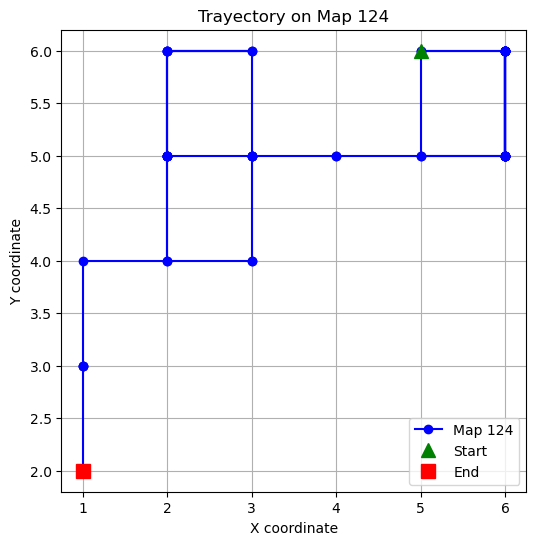

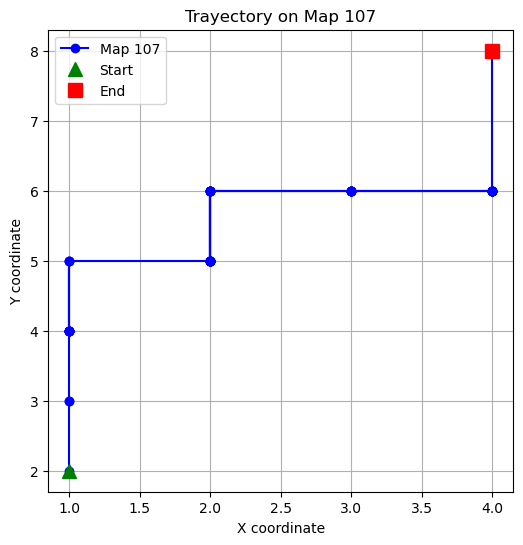

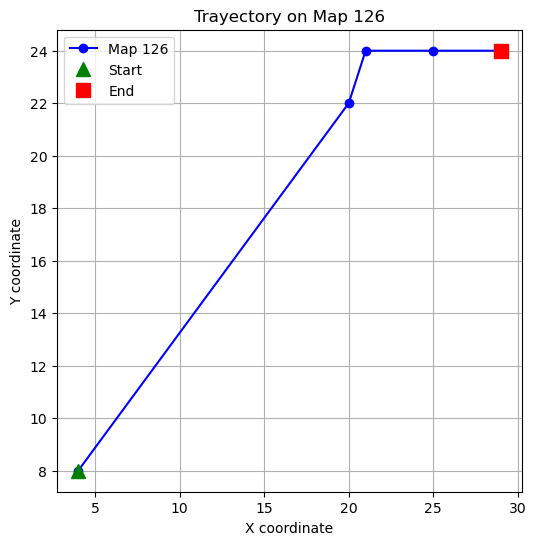

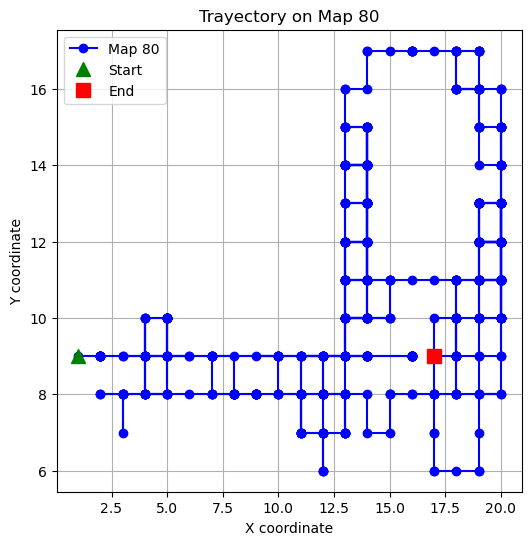

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def make_env():
    pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
    train_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)

    # Transformar observación para solo usar info relevante
    train_env = TransformObservation(
        train_env,
        lambda obs: {"info": obs["info"]},  # Solo usar posición
        observation_space=Dict({
            "info": Box(low=0, high=255, shape=(4,), dtype=np.float32)
        })
    )
    return Monitor(train_env, filename="./ppo_medarot_logs")

# Evaluate the policy on a fresh environment and visualize the trajectory
def test_policy(model):
    # Initialize a test environment
    test_env = make_env()
    obs, info = test_env.reset()

    done = False
    map_positions = {}  # Dictionary to store positions per map

    # Test the learned policy
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = test_env.step(action)  # Unpack 5 values
        
        map_id = int(obs["info"][2])  # Third value in "info" array
        position = (obs["info"][0], obs["info"][1])  # X, Y coordinates

        # Store position in the corresponding map
        if map_id not in map_positions:
            map_positions[map_id] = []
        map_positions[map_id].append(position)

    # Create a separate plot for each map
    for map_id, positions in map_positions.items():
        positions = np.array(positions)

        plt.figure(figsize=(6, 6))
        plt.plot(positions[:, 0], positions[:, 1], marker="o", linestyle="-", color="b", label=f"Map {map_id}")
        plt.plot(positions[0, 0], positions[0, 1], "g^", markersize=10, label="Start")  # Starting point
        plt.plot(positions[-1, 0], positions[-1, 1], "rs", markersize=10, label="End")  # Final point

        plt.xlabel("X coordinate")
        plt.ylabel("Y coordinate")
        plt.title(f"Trayectory on Map {map_id}")
        plt.legend()
        plt.grid()
        plt.show()

# Load the trained PPO model
model = PPO.load("a2c_medarot")  # Load your trained model

# Test the policy on a single environment and visualize the trajectory
test_policy(model)


In [5]:
from pyboy import PyBoy
from stable_baselines3 import A2C  # Importar A2C en lugar de PPO
from stable_baselines3.a2c import MultiInputPolicy  # Corrección aquí
from gymnasium.wrappers import TransformObservation
from gymnasium.spaces import Box, Dict
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv
import numpy as np

# Función para crear un entorno de entrenamiento
def make_env():
    def _init():
        pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
        train_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)

        # Transformar observación para solo usar info relevante
        train_env = TransformObservation(
            train_env,
            lambda obs: {"info": obs["info"]},  # Solo usar posición
            observation_space=Dict({
                "info": Box(low=0, high=255, shape=(4,), dtype=np.float32)
            })
        )

        # Usar Monitor para registrar métricas
        return Monitor(train_env, filename="./a2c_medarot_logs")

    return _init

# Crear entornos paralelos para acelerar el entrenamiento
num_envs = 8
vec_env = SubprocVecEnv([make_env() for _ in range(num_envs)])

# Configurar A2C
model = A2C(
    MultiInputPolicy,
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    n_steps=20,  # A2C prefiere valores pequeños (~5-20)
    gamma=0.99,  # Ligeramente menor que en PPO
    gae_lambda=1.0,  # A2C usa GAE, pero λ=1 significa ventaja normal
    ent_coef=0.01,  # Menos regularización que en PPO
    tensorboard_log="./a2c_tensorboard/"
)

# Entrenar y guardar el mejor modelo
model.learn(total_timesteps=750000)
model.save("a2c_medarot")


Using cpu device
Logging to ./a2c_tensorboard/A2C_1
------------------------------------
| time/                 |          |
|    fps                | 106      |
|    iterations         | 100      |
|    time_elapsed       | 149      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -1.79    |
|    explained_variance | 0.83     |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 0.033    |
|    value_loss         | 0.00187  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.42e+03 |
|    ep_rew_mean        | 11.6     |
| time/                 |          |
|    fps                | 109      |
|    iterations         | 200      |
|    time_elapsed       | 292      |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -1.79    |
|    explained_variance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pyboy import PyBoy

def make_env():
    pyboy = PyBoy(r"C:\Users\USUARIO\Desktop\RLMEDA\MedarotKabuto.gb")
    train_env = GenericPyBoyEnv(pyboy, debug=False, render_mode=False)

    train_env = TransformObservation(
        train_env,
        lambda obs: {"info": obs["info"]},  # Solo usar posición
        observation_space=Dict({
            "info": Box(low=0, high=255, shape=(4,), dtype=np.float32)
        })
    )
    return Monitor(train_env, filename="./ppo_medarot_logs")

def test_policy(model, map_images=None):
    test_env = make_env()
    obs, info = test_env.reset()

    done = False
    map_positions = {}

    while not done:
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, truncated, info = test_env.step(action)

        map_id = int(obs["info"][2])  # Tercer valor en "info"
        position = (obs["info"][0], obs["info"][1])  # Coordenadas X, Y
        map_positions[map_id] = []
        if map_id not in map_positions:
            #map_positions[map_id] = []
        #if position not in map_positions[map_id]:  # Evitar duplicados
            map_positions[map_id].append(position)

    for map_id, positions in map_positions.items():
        positions = np.array(positions)
        
        plt.figure(figsize=(8, 8))

        # Graficar trayectoria del agente
        plt.plot(positions[:, 0], positions[:, 1], marker="o", linestyle="-", color="b", alpha=0.6, label="Trayectoria")
        plt.plot(positions[0, 0], positions[0, 1], "g^", markersize=10, label="Inicio")
        plt.plot(positions[-1, 0], positions[-1, 1], "rs", markersize=10, label="Final")

        plt.xlabel("Posición X")
        plt.ylabel("Posición Y")
        plt.title(f"Trayectoria en el Mapa {map_id}")
        plt.legend()
        plt.grid()
        plt.show()

model = PPO.load("ppo_medarot_2")  # Cargar modelo entrenado
test_policy(model, map_images)


NameError: name 'map_images' is not defined